In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split

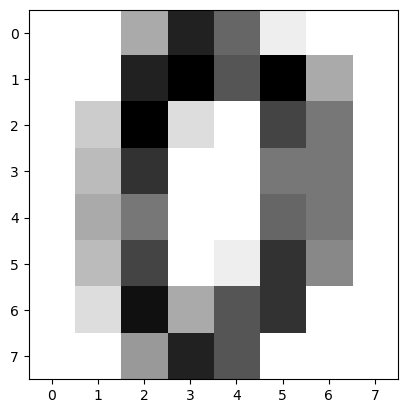

In [11]:
# MNIST 손글씨 숫자 데이터셋 로드
digits = datasets.load_digits()
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')

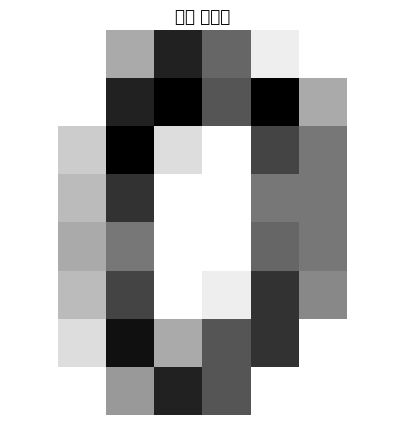

In [13]:
# 첫 번째 샘플 이미지 시각화
plt.figure(figsize=(5, 5))
plt.imshow(digits.images[0], cmap=plt.cm.gray_r, interpolation='nearest')
plt.title('샘플 이미지')
plt.axis('off')
plt.show()

In [15]:
# 데이터 전처리
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

In [17]:
# 표준화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 훈련/테스트 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

In [23]:
# 데이터셋 및 데이터로더 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [27]:
# 모델 정의 (다중 분류)
class DigitsMultiClassDNN(nn.Module):
    def __init__(self):
        super(DigitsMultiClassDNN, self).__init__()
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 10)  # 10 클래스 분류
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)  # CrossEntropyLoss는 softmax 없이 logits 입력 받음
        return x

In [31]:
# 모델, 손실함수, 옵티마이저 정의
model = DigitsMultiClassDNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [39]:
train_losses = []
test_accuracies = []
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # 테스트 정확도 평가
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

Epoch 1/20, Loss: 2.2189, Accuracy: 49.13%
Epoch 2/20, Loss: 1.8795, Accuracy: 77.17%
Epoch 3/20, Loss: 1.2989, Accuracy: 85.66%
Epoch 4/20, Loss: 0.7224, Accuracy: 90.05%
Epoch 5/20, Loss: 0.4122, Accuracy: 93.60%
Epoch 6/20, Loss: 0.2723, Accuracy: 95.48%
Epoch 7/20, Loss: 0.2029, Accuracy: 96.17%
Epoch 8/20, Loss: 0.1627, Accuracy: 97.15%
Epoch 9/20, Loss: 0.1314, Accuracy: 97.43%
Epoch 10/20, Loss: 0.1123, Accuracy: 98.12%
Epoch 11/20, Loss: 0.0948, Accuracy: 98.61%
Epoch 12/20, Loss: 0.0810, Accuracy: 98.82%
Epoch 13/20, Loss: 0.0705, Accuracy: 99.16%
Epoch 14/20, Loss: 0.0638, Accuracy: 99.16%
Epoch 15/20, Loss: 0.0546, Accuracy: 99.37%
Epoch 16/20, Loss: 0.0482, Accuracy: 99.37%
Epoch 17/20, Loss: 0.0426, Accuracy: 99.37%
Epoch 18/20, Loss: 0.0383, Accuracy: 99.58%
Epoch 19/20, Loss: 0.0344, Accuracy: 99.65%
Epoch 20/20, Loss: 0.0304, Accuracy: 99.72%


In [43]:
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# 모델 평가 모드로 전환 (Dropout, BatchNorm 비활성화)
model.eval()

# 예측 및 라벨 저장용 리스트
all_labels = []
all_predictions = []

# 평가 시에는 그래디언트 비활성화 → 속도 & 메모리 최적화
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)  # 순전파
        _, predicted = torch.max(outputs.data, 1)  # 가장 높은 확률의 클래스 선택

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 리스트를 numpy 배열로 변환
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 혼동 행렬 및 기본 평가 지표 계산
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# 클래스별 Specificity 계산
specificity = []
with np.errstate(divide='ignore', invalid='ignore'):  # 0으로 나누는 경우 방지
    for i in range(conf_matrix.shape[0]):
        tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
        fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
        spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0
        specificity.append(spec)

# 결과 출력
print("=== 모델 평가 결과 ===")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"F1 Score      : {f1:.4f}")
print(f"Precision     : {precision:.4f}")
print(f"Recall        : {recall:.4f}")
print(f"Specificity   : {np.mean(specificity):.4f}")

=== 모델 평가 결과 ===
Confusion Matrix:
[[33  0  0  0  0  0  0  0  0  0]
 [ 0 28  0  0  0  0  0  0  0  0]
 [ 0  0 33  0  0  0  0  0  0  0]
 [ 0  0  1 32  0  1  0  0  0  0]
 [ 0  0  0  0 46  0  0  0  0  0]
 [ 0  0  0  0  0 45  1  0  0  1]
 [ 1  0  0  0  0  0 34  0  0  0]
 [ 0  0  0  0  0  1  0 33  0  0]
 [ 0  1  0  0  0  1  0  0 28  0]
 [ 0  0  0  2  0  0  0  0  1 37]]
F1 Score      : 0.9693
Precision     : 0.9696
Recall        : 0.9694
Specificity   : 0.9966


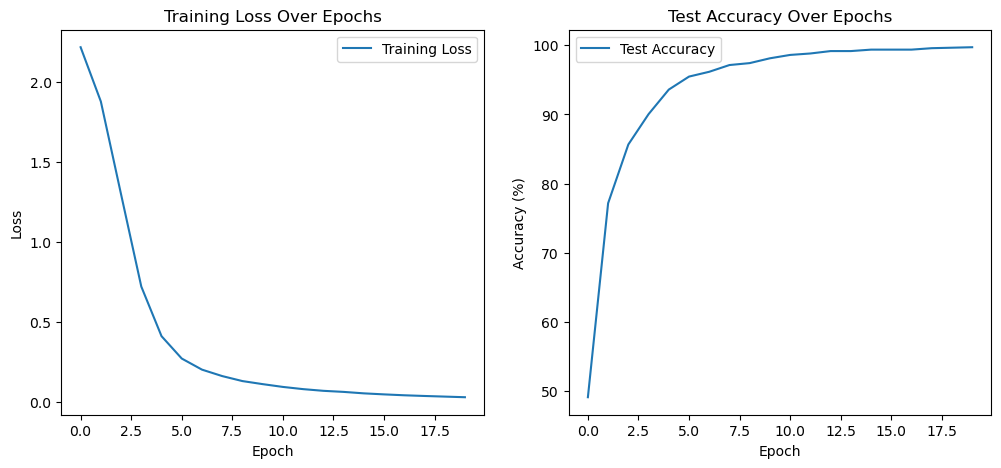

In [45]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()